# Evaluate

In [26]:
import logging
from os import listdir
from os.path import join
import pickle
import nltk
import json

import torch
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC

import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

from code.model import NativeLanguageCNN
from code.train import read_data
from scripts.baseline_util import ivectors_dict_to_features

### Read dev set data

In [30]:
feature_dir = "data/features/speech_transcriptions/ngrams/2"
dev_label_file = "data/labels/dev/labels.dev.csv"
max_len = 600

In [31]:
# Read feature dictionary
with open(join(feature_dir, 'dict.pkl'), 'rb') as fpkl:
    (feature_dict, feature_rev_dict) = pickle.load(fpkl)
n_features = len(feature_dict)

# Read dev set data + labels
(dev_mat, dev_label, _, _, lang_dict) = read_data(join(feature_dir, 'dev'),
                                                  dev_label_file, 0., n_features, max_len)

n_lang = len(lang_dict)
print(dev_mat.shape)
print(len(dev_label))

(1100, 600)
1100


### Restore model from state

In [4]:
model_state_file = "model/2017-06-02-125700/model-state-0050.pkl"

max_len = 600
embed_dim = 500
channel = 500

In [5]:
def restore_model(model_state_file, max_len, embed_dim, channel, cuda=None):
    nlcnn_model = NativeLanguageCNN(n_features, embed_dim, 0, channel, n_lang)
    map_location = {'cuda:0':'cpu'}
    if cuda:
        nlcnn_model.cuda(0)
        map_location = {'cuda:0':'cuda:0'}
    nlcnn_model.load_state_dict(torch.load(model_state_file, map_location={'cuda:0':'cpu'}))
    nlcnn_model.eval()
    return nlcnn_model

In [6]:
nlcnn_model = restore_model(model_state_file, max_len, embed_dim, channel)

## Model evaluation

### Confusion Matrices and F1 Scores

In [24]:
def evaluate_model(model, dev_mat, cuda=False):
    model.eval()
    dev_mat_var = Variable(torch.from_numpy(dev_mat).cuda() if cuda
                           else torch.from_numpy(dev_mat))
    dev_score = model(dev_mat_var)
    return dev_score

def get_conf_f1(dev_pred, dev_label):
    dev_pred_lang = [lang_dict[lb] for lb in dev_pred]
    dev_lang = [lang_dict[lb] for lb in dev_label]
    conf_mat = confusion_matrix(dev_lang, dev_pred_lang)
    f1 = f1_score(dev_lang, dev_pred_lang, average='weighted')
    return (conf_mat, f1)

def plot_conf_mat(conf_mat, lang_label):
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.set_style("white")
    sns.heatmap(conf_mat, annot=True, cmap=cmap, fmt="d", linewidths=1, square=True,
                xticklabels=lang_label, yticklabels=lang_label)

/usr/lib/anaconda3/envs/sergey/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


F1 = 48.413%


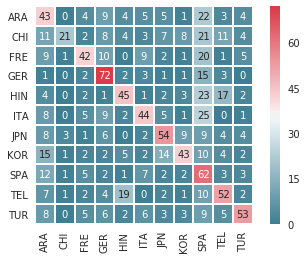

In [25]:
dev_score = evaluate_model(nlcnn_model, dev_mat)
dev_pred = np.argmax(dev_score.data.cpu().numpy(), axis=1)
(conf_mat, f1) = get_conf_f1(dev_pred, dev_label)
languages = sorted(lang_dict.values())
plot_conf_mat(conf_mat, languages)
print("F1 = {:.3%}".format(f1))

## Network Visualization

### Arpabet Embeddings

In [103]:
def plot_embeddings(wv, vocab):
    tsne = TSNE(n_components=2, random_state=0)
#     np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(wv)

    plt.figure(figsize=(15, 10))
    plt.scatter(Y[:, 0], Y[:, 1])
    for label, x, y in zip(vocab, Y[:, 0], Y[:, 1]):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.show()

/usr/lib/anaconda3/envs/sergey/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


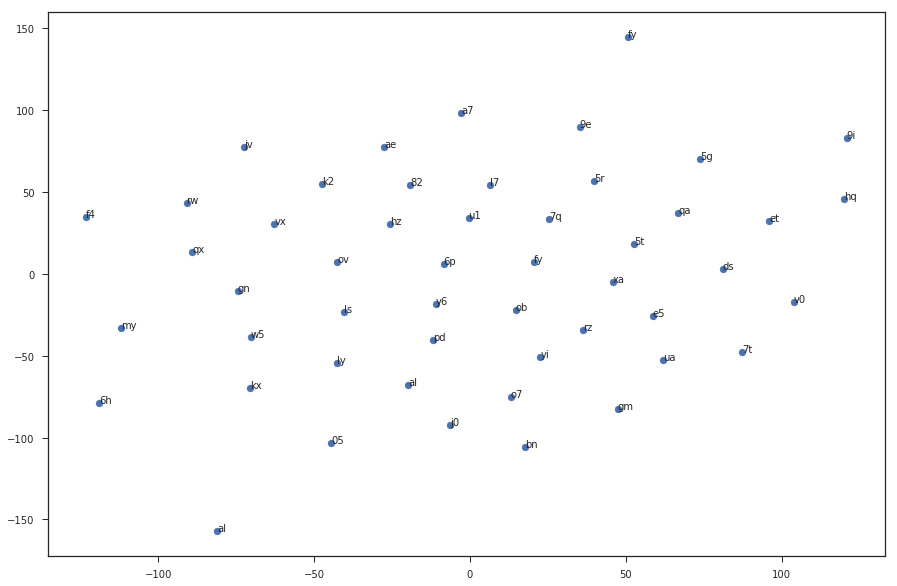

In [107]:
with open(join(feature_dir, 'dict.pkl'), 'rb') as fpkl:
    (feature_dict, feature_rev_dict) = pickle.load(fpkl)

embeddings = nlcnn_model.embed.weight.data.cpu().numpy()
indices = np.random.choice(embeddings.shape[0] - 1, 50)
bigrams = [''.join(feature_dict[i]) for i in indices]
plot_embeddings(embeddings[indices], bigrams)

### Saliency maps

In [94]:
file_dir = "data/speech_transcriptions/dev/tokenized"
file_list = sorted(listdir(file_dir))

df_label = pd.read_csv(label)
test_taker_id = df_label['test_taker_id'].tolist()

In [177]:
def get_embed_grad(model, X, y):
    model.eval()
    X_var = Variable(X).unsqueeze(0)
    scores = model(X_var)
    loss = scores[0, y]
    loss.backward()
    embed_grad = model.embed.weight.grad.sum(dim=1).abs().squeeze().data
    return embed_grad.numpy()

def plot_saliency_map(model, X, y, test_id=None, width=20):
    if not test_id:
        test_id = np.random.choice(test_taker_id)
    idx = test_taker_id.index(test_id)
    print(df_label.iloc[idx])
    
    embed_grad = get_embed_grad(model, torch.LongTensor(X[idx]), y[idx])
    lines = open(join(file_dir, file_list[idx])).readlines()
    
    for (l, ln) in enumerate(lines):
        ln_low = ln.lower()
        grad = []
        annot = []
        
        for i in range(len(ln) - 1):
            if ln[i] is ' ':
                annot.append(ln[i])
                grad.append(0)
                continue
                
            bigram = (ln_low[i], ln_low[i + 1])
            if ln_low[i + 1] == ' ':
                bigram = (ln_low[i], ln_low[i + 2])
            if bigram not in feature_rev_dict:
                annot.append(ln[i])
                grad.append(0)
                continue
            
            annot.append(ln[i])
            grad.append(embed_grad[feature_rev_dict[bigram]])
        
        plt.figure(figsize=(8, 10))
        grad += [0] * (width - len(grad) % width)
        annot += [''] * (width - len(annot) % width)
        grad = np.array(grad).reshape(-1, width)
        annot = np.array(annot).reshape(-1, width)
        sns.set_style("white")
        cmap = sns.cubehelix_palette(5, dark=0, light=1, rot=-.25, as_cmap=True)
        sns.heatmap(grad, annot=annot, fmt = '', square=True, cbar=False, cmap=cmap,
                    xticklabels=[''] * grad.shape[0], yticklabels=[''] * grad.shape[1])
        plt.show()

test_taker_id    12993
speech_prompt       P9
essay_prompt        P0
L1                 GER
Name: 1081, dtype: object


/usr/lib/anaconda3/envs/sergey/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


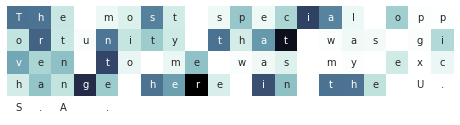

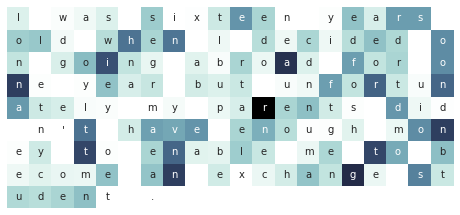

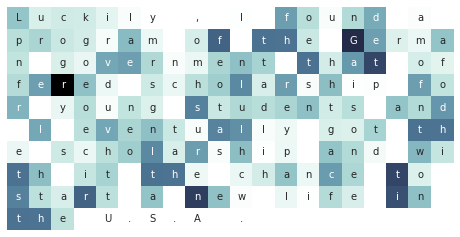

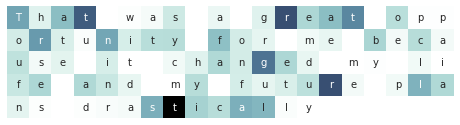

In [178]:
plot_saliency_map(nlcnn_model, dev_mat, dev_label, width=20)

## Combined SVM Evaluation

### Confusion Matrices and F1 Scores

In [32]:
train_ivectors_path = 'data/features/ivectors/train/ivectors.json'
dev_ivectors_path = 'data/features/ivectors/dev/ivectors.json'
train_label_file = "data/labels/train/labels.train.csv"

In [ ]:
(train_mat, train_label, _, _, _) = read_data(join(feature_dir, 'train'),
                                              train_label_file, 0., n_features, max_len)
train_score = evaluate_model(nlcnn_model, train_mat).data.cpu().numpy()
dev_score = dev_score.data.cpu().numpy()

train_ivectors_dict = json.load(open(train_ivectors_path))
dev_ivectors_dict = json.load(open(dev_ivectors_path))
train_ivectors_mat = ivectors_dict_to_features(train_ivectors_dict, 'train')
dev_ivectors_mat = ivectors_dict_to_features(dev_ivectors_dict, 'dev')

In [27]:
train_combined_mat = np.hstack((train_score, train_ivectors_mat))
dev_combined_mat = np.hstack((dev_score, dev_ivectors_mat))
clf = LinearSVC()
clf.fit(train_combined_mat, train_label)

NameError: name 'combined_train_features' is not defined

In [21]:
predicted = clf.predict(combined_mat)

(1100, 811)